In [1]:
!pip install mysql-connector-python

## Importing libraries

In [2]:
#importing matplot
import matplotlib.pyplot as plt 

#importing numpy
import numpy as np 

# Set plot space as inline for inline plots display
%matplotlib inline

# importing pandas into jupyter notebook
import pandas as pd

## Importing data from SQL database

In [3]:
#importing SQL connector
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

In [4]:
#importing Box office database
# box_m = pd.read_sql_query('select * from bom_movie_gross', con)
df = pd.read_sql_query("""
                         SELECT  title, studio, bom_movie_gross.domestic_gross, 
                                 foreign_gross, year, tconst, runtime_minutes, genres, 
                                 averagerating, numvotes, directors, writers, production_budget
                         FROM movies.bom_movie_gross
                         JOIN imdb_title_basics
                         ON title = primary_title
                         JOIN imdb_title_ratings
                         USING (tconst)
                         JOIN imdb_title_crew
                         USING (tconst)
                         JOIN tn_movie_budgets
                         ON title = movie;
                         """, con)

## Cleaning the dataset

In [5]:
# creating new database with split value columns
directors = df["directors"].str.split(",", n = 1, expand = True)
# making separate director columns from new data frame 
df["director1"]= directors[0] 
df["director2"]= directors[1]
# Dropping old directors columns 
df.drop(columns =["directors"], inplace = True)
# creating total gross column
df["total_gross"]= df['domestic_gross'] + df['foreign_gross']
# cleaning production budget into integers
df['production_budget'] = df['production_budget'].str.replace(',', '')
df['production_budget'] = df['production_budget'].str.replace('$', '')
df['production_budget'] = df['production_budget'].astype(int)
# creating ROI column
df["ROI"]= (df['total_gross'] / df['production_budget']) -1 
# removing empty cells
df['total_gross'].replace('', np.nan, inplace=True)
df.dropna(subset=['total_gross'], inplace=True)
# converting columns to integer
df['total_gross'] = df['total_gross'].astype(int)
df['domestic_gross'] = df['domestic_gross'].astype(int)
df['foreign_gross'] = df['foreign_gross'].astype(int)
df.head()

,title,studio,domestic_gross,foreign_gross,year,tconst,runtime_minutes,genres,averagerating,numvotes,writers,production_budget,director1,director2,total_gross,ROI
0,Toy Story 3,BV,415000000,652000000,2010,tt0435761,103.0,"Adventure,Animation,Comedy",8.3,682218,"nm0005124,nm0004056,nm0881279,nm1578335",200000000,nm0881279,None,1067000000,4.335000
1,Inception,WB,292600000,535700000,2010,tt1375666,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,nm0634240,160000000,nm0634240,None,828300000,4.176875
2,Shrek Forever After,P/DW,238700000,513900000,2010,tt0892791,93.0,"Adventure,Animation,Comedy",6.3,167532,"nm0825308,nm0458441,nm0501359,nm0011470,nm0254...",165000000,nm0593610,None,752600000,3.561212
3,The Twilight Saga: Eclipse,Sum.,300500000,398000000,2010,tt1325004,124.0,"Adventure,Drama,Fantasy",5.0,211733,"nm0742279,nm2769412",68000000,nm1720541,None,698500000,9.272059
4,Iron Man 2,Par.,312400000,311500000,2010,tt1228705,124.0,"Action,Adventure,Sci-Fi",7.0,657690,"nm0857620,nm0498278,nm1411347,nm1293367,nm0456158",170000000,nm0269463,None,623900000,2.670000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264 entries, 0 to 1471
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1264 non-null   object 
 1   studio             1264 non-null   object 
 2   domestic_gross     1264 non-null   int32  
 3   foreign_gross      1264 non-null   int32  
 4   year               1264 non-null   int64  
 5   tconst             1264 non-null   object 
 6   runtime_minutes    1233 non-null   float64
 7   genres             1264 non-null   object 
 8   averagerating      1264 non-null   float64
 9   numvotes           1264 non-null   int64  
 10  writers            1223 non-null   object 
 11  production_budget  1264 non-null   int32  
 12  director1          1264 non-null   object 
 13  director2          124 non-null    object 
 14  total_gross        1264 non-null   int32  
 15  ROI                1264 non-null   float64
dtypes: float64(3), int32(4),

### Question - Who are the most successful directors to partner with to make a scusessful horror movie? 

Of the top 10 successful directors, only one has successfuly delivered an average postive ROI

<BarContainer object of 10 artists>

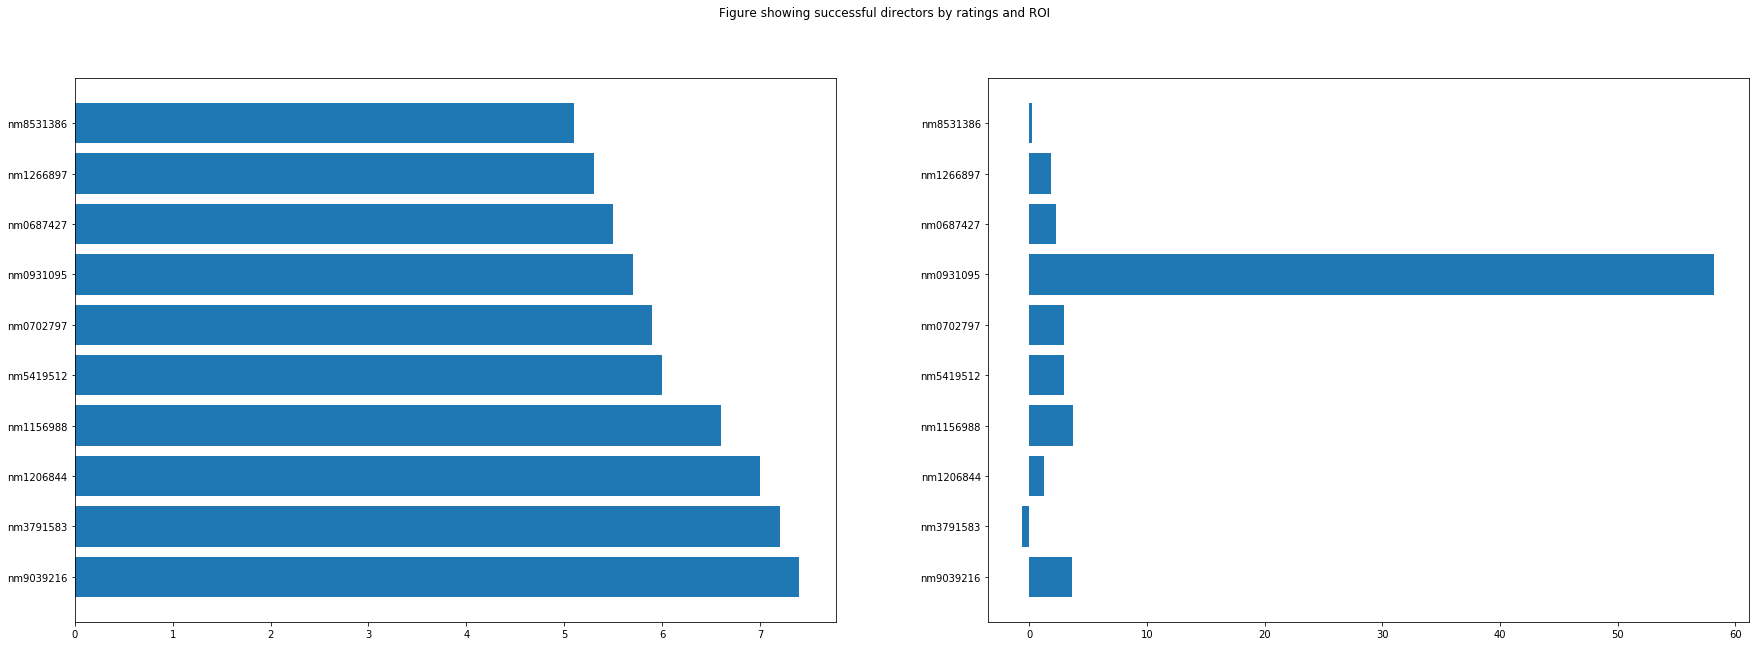

In [76]:
# analyzing data to identify top 10 directors by average ratings

mov_dir.dropna(subset=['director1'], inplace=True)  #droping empty cells in director column
mov_dir['director1'].replace('', np.nan, inplace=True)
mov_dir = df[df['genres'] == 'Horror'] # filtering for a specific genre
# mov_dir = mov_dir.loc[mov_dir['numvotes'] >= 500]
# mov_dir = mov_dir[mov_dir['numvotes'] >= 1000]
mov_dir = mov_dir.groupby(['director1', 'genres']).mean().reset_index()
mov_dir = mov_dir.sort_values(["averagerating"], ascending = False) #sorting values from highest to lowest
mov_dir = mov_dir.head(10)
# print(mov_dir)

# ploting figure to show top 10 directors by average ratings and their ROIs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle('Figure showing successful directors by ratings and ROI')
ax1.barh(mov_dir['director1'], mov_dir['averagerating'])
ax2.barh(mov_dir['director1'], mov_dir['ROI'])

In [56]:
mov_dir.describe()

,domestic_gross,foreign_gross,year,runtime_minutes,averagerating,numvotes,production_budget,total_gross,ROI
count,1.600000e+01,1.600000e+01,16.000000,15.000000,16.000000,16.000000,1.600000e+01,1.600000e+01,16.000000
mean,5.613981e+07,8.863750e+07,2013.125000,87.266667,5.362500,36765.875000,3.709219e+07,1.447773e+08,12.499859
std,6.308328e+07,1.603753e+08,2.729469,7.544787,1.325582,86661.761748,4.900479e+07,2.190794e+08,27.468449
min,2.370000e+05,4.000000e+06,2010.000000,74.000000,2.600000,6.000000,5.000000e+05,4.237000e+06,-0.588571
25%,1.087500e+07,8.750000e+06,2010.750000,82.000000,4.500000,18.000000,5.375000e+06,2.262500e+07,1.185500
50%,4.235000e+07,2.315000e+07,2012.500000,87.000000,5.400000,113.500000,2.500000e+07,5.940000e+07,2.628249
75%,6.620000e+07,7.105000e+07,2015.000000,93.500000,6.150000,20240.250000,3.775000e+07,1.618250e+08,4.637419
max,2.097000e+08,5.974000e+08,2018.000000,98.000000,7.400000,338445.000000,1.750000e+08,8.071000e+08,100.800000


### Question - What are the common runtimes by genre?

<BarContainer object of 10 artists>

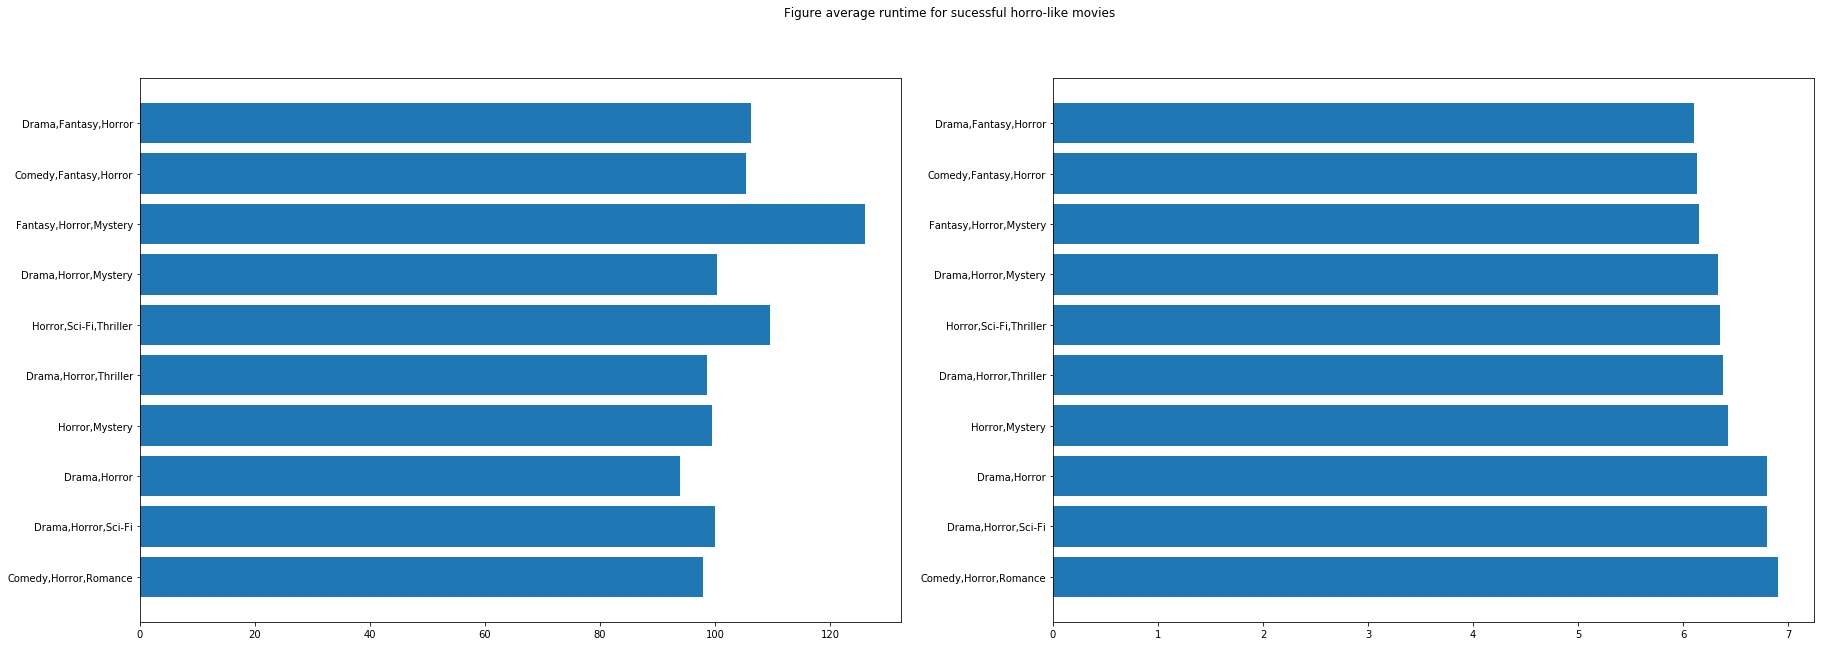

In [67]:
# analyzing data to identify top 10 directors by average ratings

# mov_dir = df[df['genres'] == 'Horror'] # filtering for a specific genre
#gen_time = df.loc[df['numvotes'] >= 1000]
gen_time = df[df['genres'].str.contains("Horror")]
gen_time = gen_time.groupby(['genres']).mean().reset_index()
gen_time = gen_time.sort_values(["averagerating"], ascending = False) #sorting values from highest to lowest
gen_time = gen_time.head(10)
gen_time

# ploting figure to show top 10 directors by average ratings and their ROIs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle('Figure average runtime for sucessful horro-like movies')
ax1.barh(gen_time['genres'], gen_time['runtime_minutes'])
ax2.barh(gen_time['genres'], gen_time['averagerating'])

In [68]:
# # mov_dir = df[df['genres'] == 'Drama'] 
# mov_dir = mov_dir.groupby(['director1', 'genres']).mean().reset_index().head(10)
# mov_dir['director1'].replace('', np.nan, inplace=True)
# mov_dir.dropna(subset=['director1'], inplace=True)
# mov_dir = mov_dir.sort_values(["ROI", "averagerating"], ascending = (False, False))
# mov_dir

In [69]:
# c = df.genres.value_counts()
# countzz = pd.DataFrame(c)
# countzz

In [70]:
# mov_dir_ROI = df[df['genres'] == 'Horror'] 
# mov_dir_ROI = mov_dir_ROI.groupby(['director1', 'genres']).mean().reset_index().head(10)
# mov_dir_ROI['director1'].replace('', np.nan, inplace=True)
# mov_dir_ROI.dropna(subset=['director1'], inplace=True)
# mov_dir_ROI = mov_dir_ROI.sort_values(["ROI"], ascending = False)
# mov_dir_ROI

In [71]:
df.head()

,title,studio,domestic_gross,foreign_gross,year,tconst,runtime_minutes,genres,averagerating,numvotes,writers,production_budget,director1,director2,total_gross,ROI
0,Toy Story 3,BV,415000000,652000000,2010,tt0435761,103.0,"Adventure,Animation,Comedy",8.3,682218,"nm0005124,nm0004056,nm0881279,nm1578335",200000000,nm0881279,None,1067000000,4.335000
1,Inception,WB,292600000,535700000,2010,tt1375666,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,nm0634240,160000000,nm0634240,None,828300000,4.176875
2,Shrek Forever After,P/DW,238700000,513900000,2010,tt0892791,93.0,"Adventure,Animation,Comedy",6.3,167532,"nm0825308,nm0458441,nm0501359,nm0011470,nm0254...",165000000,nm0593610,None,752600000,3.561212
3,The Twilight Saga: Eclipse,Sum.,300500000,398000000,2010,tt1325004,124.0,"Adventure,Drama,Fantasy",5.0,211733,"nm0742279,nm2769412",68000000,nm1720541,None,698500000,9.272059
4,Iron Man 2,Par.,312400000,311500000,2010,tt1228705,124.0,"Action,Adventure,Sci-Fi",7.0,657690,"nm0857620,nm0498278,nm1411347,nm1293367,nm0456158",170000000,nm0269463,None,623900000,2.670000


### Question - genre by ROI

<BarContainer object of 10 artists>

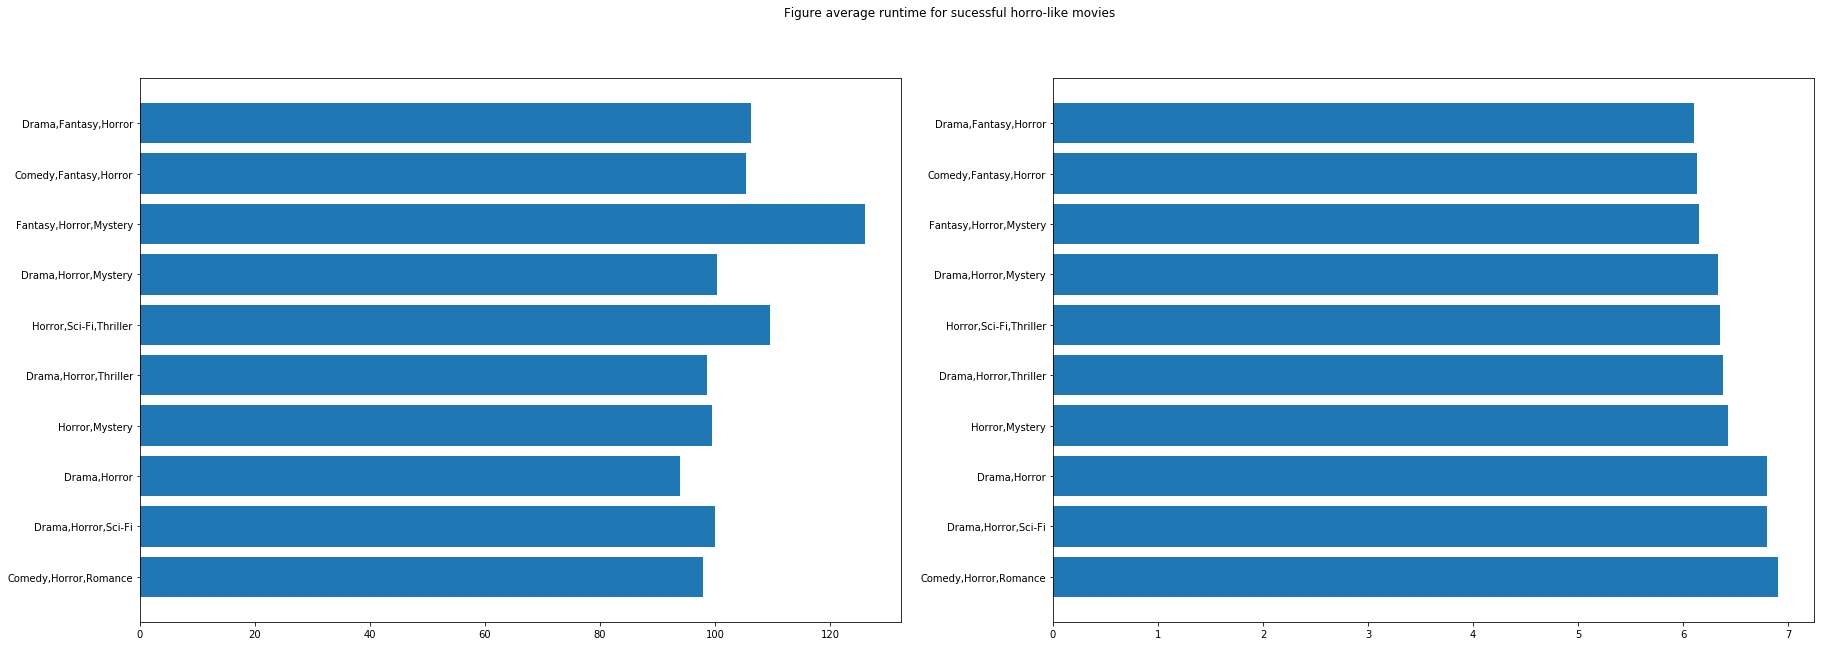

In [77]:
# mov_dir = df[df['genres'] == 'Horror'] # filtering for a specific genre
#gen_time = df.loc[df['numvotes'] >= 1000]
# gen_time = df[df['genres'].str.contains("Horror")]
gen_ROI = df.groupby(['genres']).mean().reset_index()
gen_ROI = gen_ROI.sort_values(["ROI"], ascending = False) #sorting values from highest to lowest
# gen_time = gen_time.head(10)
gen_ROI

# ploting figure to show top 10 directors by average ratings and their ROIs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle('Figure average runtime for sucessful horro-like movies')
ax1.barh(gen_time['genres'], gen_time['runtime_minutes'])
ax2.barh(gen_time['genres'], gen_time['averagerating'])

In [75]:
gen_ROI.describe()

,domestic_gross,foreign_gross,year,runtime_minutes,averagerating,numvotes,production_budget,total_gross,ROI
count,2.030000e+02,2.030000e+02,203.000000,202.000000,203.000000,2.030000e+02,2.030000e+02,2.030000e+02,203.000000
mean,6.212866e+07,8.850263e+07,2013.432693,105.942721,6.403155,1.221991e+05,4.598929e+07,1.506313e+08,3.358945
std,7.099384e+07,1.232044e+08,1.856468,17.938675,0.902267,1.534898e+05,3.916310e+07,1.896563e+08,5.136536
min,8.000000e+02,4.070000e+04,2010.000000,41.500000,2.100000,8.000000e+00,4.000000e+05,2.280000e+05,-0.986971
25%,2.442982e+07,2.228750e+07,2012.000000,97.187500,5.982857,3.452585e+04,1.937500e+07,4.745000e+07,0.881339
50%,4.430000e+07,5.033750e+07,2013.375000,105.000000,6.418182,8.671564e+04,3.480000e+07,9.430000e+07,2.069091
75%,6.723840e+07,9.996150e+07,2014.500000,114.982143,6.910000,1.603533e+05,5.825000e+07,1.655151e+08,3.950824
max,4.126000e+08,8.757000e+08,2018.000000,165.000000,9.200000,1.211405e+06,2.316667e+08,1.276400e+09,35.090232
